In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error as mae
import seaborn as sns
sns.set_theme()
sns.set(font_scale=0.8)
    
from solardatatools.solar_noon import energy_com

# for CVXPY implementation
from solardatatools.cvx_signal_decompositions import l2_l1d1_l2d2p365 as cvx_sd

# for OSD implementation
from solardatatools.osd_signal_decompositions import l2_l1d1_l2d2p365 as osd_sd
from gfosd.components import *
from gfosd import Problem

# Import data from `tests/fixtures`

In [2]:
# Import data
fixtures_path = "/Users/smiskov/Documents/SLAC/PVInsight/solar-data-tools/tests/fixtures/"

input_power_signals_file_path = Path(fixtures_path + "time_shifts/two_year_signal_with_shift.csv")
with open(input_power_signals_file_path) as file:
    power_data_matrix = np.loadtxt(file, delimiter=",")

use_days_file_path = Path(fixtures_path + "time_shifts/clear_days.csv")
with open(use_days_file_path) as file:
    use_days = np.loadtxt(file, delimiter=",")

output_power_signals_file_path = Path(fixtures_path + "time_shifts/two_year_signal_fixed.csv")
with open(output_power_signals_file_path) as file:
    expected_power_data_fix = np.loadtxt(file, delimiter=",")

## Preprocess data to obtain metric

In [3]:
# Estimate solar noon
metric = energy_com(power_data_matrix)   # does not depend on any SDs
use_ixs = np.logical_and(use_days, ~np.isnan(metric))

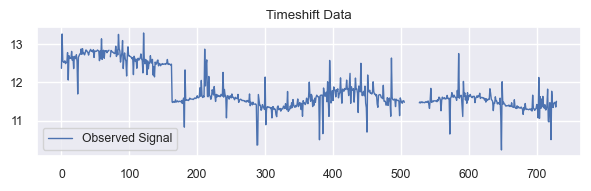

In [6]:
# plot observed
f, ax = plt.subplots(1, 1, figsize=(6,2))
ax.plot(metric, linewidth=1, label="Observed Signal");
ax.set_title("Timeshift Data")
plt.tight_layout()
ax.legend();
#plt.savefig("timeshift_data", dpi=300)

# Run simple test

CVXPY objective       13.36868
OSD objective, scaled 12.31449
MAE s_hat  (OSD+MOSEK,CVX)   1.59e-06
MAE s_seas (OSD+MOSEK,CVX)   1.17e-06
MAE s_hat  (OSD+QSS,CVX)   4.72e-03
MAE s_seas (OSD+QSS,CVX)   2.41e-03


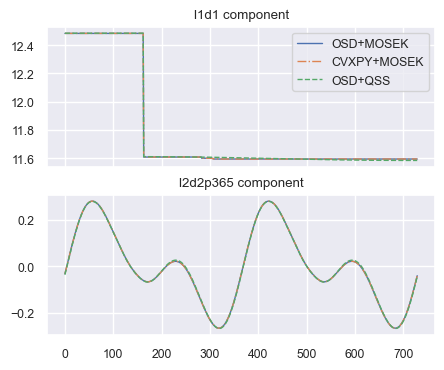

In [8]:
cvx_t1 = cvx_sd(metric, c1=100, c2=5e5, use_ixs=use_ixs, solver="MOSEK")
osd_t1 = osd_sd(metric, w1=100, w2=5e5, use_ixs=use_ixs, solver="MOSEK")
osd_qss_t1 = osd_sd(metric, w1=100, w2=5e5, use_ixs=use_ixs, solver="QSS")

# get scaled obj from cvxpy
cvx_sd(metric, c1=10, c2=500, use_ixs=use_ixs, solver="MOSEK", comp_osd=osd_t1)
print(f'MAE s_hat  (OSD+MOSEK,CVX)   {mae(cvx_t1[0], osd_t1[0]):.2e}')
print(f'MAE s_seas (OSD+MOSEK,CVX)   {mae(cvx_t1[1], osd_t1[1]):.2e}')

print(f'MAE s_hat  (OSD+QSS,CVX)   {mae(cvx_t1[0], osd_qss_t1[0]):.2e}')
print(f'MAE s_seas (OSD+QSS,CVX)   {mae(cvx_t1[1], osd_qss_t1[1]):.2e}')

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(5,4))
ax1.plot(osd_t1[0], label="OSD+MOSEK", linewidth=1)
ax1.plot(cvx_t1[0], label="CVXPY+MOSEK", linewidth=1, linestyle="-.")
ax1.plot(osd_qss_t1[0], label="OSD+QSS", linewidth=1, linestyle="--")
ax1.set_title("l1d1 component")
ax2.plot(osd_t1[1], linewidth=1)
ax2.plot(cvx_t1[1], linewidth=1, linestyle="-.")
ax2.plot(osd_qss_t1[1], label="OSD+QSS", linewidth=1, linestyle="--")
ax2.set_title("l2d2p365 component")
ax1.legend();
#plt.savefig("l2_l1d1_l2d2p365_real", dpi=300)

# Add transition locations

In [9]:
# find indices of transition points
cvx_index_set = np.arange(len(cvx_t1[0]) - 1)[np.round(np.diff(cvx_t1[0], n=1), 3) != 0]

In [10]:
# find indices of transition points
osd_index_set = np.arange(len(osd_t1[0]) - 1)[np.round(np.diff(osd_t1[0], n=1), 3) != 0]

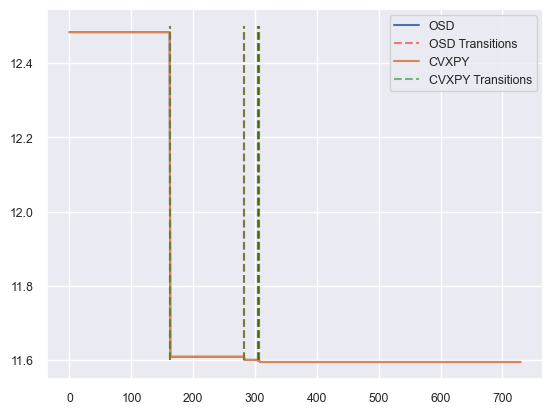

In [11]:
plt.plot(osd_t1[0], label="OSD")
for x_idx in osd_index_set:
    label = "OSD Transitions" if x_idx==osd_index_set[0] else None
    plt.vlines(x_idx, 11.6, 12.5, color="red", alpha=0.5, linestyle="--", label=label)
plt.plot(cvx_t1[0], label="CVXPY")
for x_idx in cvx_index_set:
    label = "CVXPY Transitions" if x_idx==cvx_index_set[0] else None
    plt.vlines(x_idx, 11.6, 12.5, color="green", alpha=0.5, linestyle="--", label=label)
plt.legend()
plt.show()

## Running with transition locs for CVXPY and SumCard for OSD

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


CVXPY objective       20.49696
OSD objective, scaled 2936156.09622
MAE s_hat  (OSD,CVX)   4.81e-01
MAE s_seas (OSD,CVX)   4.91e-01


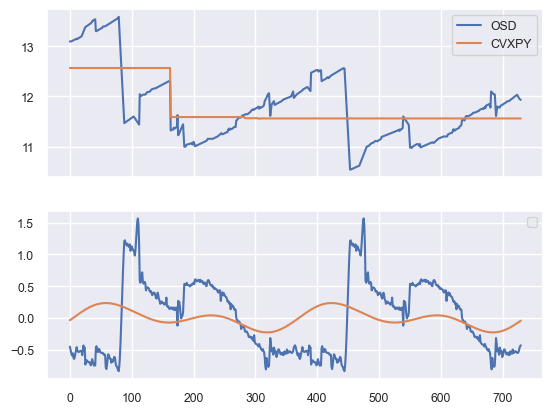

In [14]:
cvx_t2 = cvx_sd(metric,
                c1=100,
                c2=5e5,
                use_ixs=use_ixs, 
                transition_locs=cvx_index_set, 
                solver="MOSEK"
               )

osd_t2 = osd_sd(metric,
                w1=1/len(metric), 
                w2=1e-3,
                use_ixs=use_ixs, 
                sum_card=True,
                solver="QSS")

# get scaled obj from cvxpy
cvx_sd(metric,
       c1=10,
       c2=5e5,
       use_ixs=use_ixs, 
       comp_osd=osd_t2)

print(f'MAE s_hat  (OSD,CVX)   {mae(cvx_t2[0], osd_t2[0]):.2e}')
print(f'MAE s_seas (OSD,CVX)   {mae(cvx_t2[1], osd_t2[1]):.2e}')

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(osd_t2[0], label="OSD")
ax1.plot(cvx_t2[0], label="CVXPY")
ax2.plot(osd_t2[1])
ax2.plot(cvx_t2[1])
ax1.legend()
ax2.legend()
plt.show()

## Try of range of weights for l1d1 and SumCard (c1 and w1)

In [52]:
# c1s = np.logspace(1, 3, 20)
# c1s

In [51]:
# cvx_c1s_results = {}
# osd_c1s_results = {}

# for c_iter in c1s:
#     print(c_iter)
#     cvx_c1s_results[f"{c_iter}"] = cvx_sd(metric,
#                     c1=100,
#                     c2=500,
#                     use_ixs=use_ixs, 
#                     transition_locs=None, 
#                     solver="MOSEK"
#                    )

#     osd_c1s_results[f"{c_iter}"] = osd_sd(metric,
#                     w1=0.5, 
#                     w2=c_iter,
#                     use_ixs=use_ixs, 
#                     sum_card=True,
#                     solver="QSS")
    
#     # plot
#     osd_t3 = osd_c1s_results[f"{c_iter}"]
#     cvx_t3 = cvx_c1s_results[f"{c_iter}"]
    
#     f, (ax1) = plt.subplots(1, 1, figsize=(4,2))
#     ax1.plot(osd_t3[1], label="OSD")
#     ax1.plot(cvx_t3[1], label="CVXPY")
#     # ax2.plot(osd_t3[1])
#     # ax2.plot(cvx_t3[1])
#     ax1.legend()
#     plt.show()

# Simpler test

### SumAbs

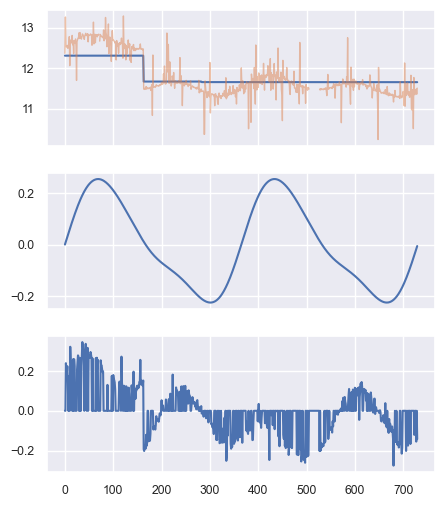

In [48]:
c1 = SumSquare(weight=1/len(metric)) # error
c2 = SumAbs(weight=0.05, diff=1) # s_hat
c3 = Aggregate([SumSquare(weight=1000, diff=2), AverageEqual(0, period=365), Periodic(365)]) # seasonal

problem = Problem(metric, [c1,c2,c3], use_set=use_ixs)
problem.decompose()

s_error =  problem.decomposition[0]
s_hat = problem.decomposition[1]
s_seas =  problem.decomposition[2]

f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(5,6), sharex=True)

ax1.plot(s_hat)
ax1.plot(metric, linewidth=1, alpha=0.5)
ax2.plot(s_seas)
ax3.plot(s_error)

plt.show()

### SumCard

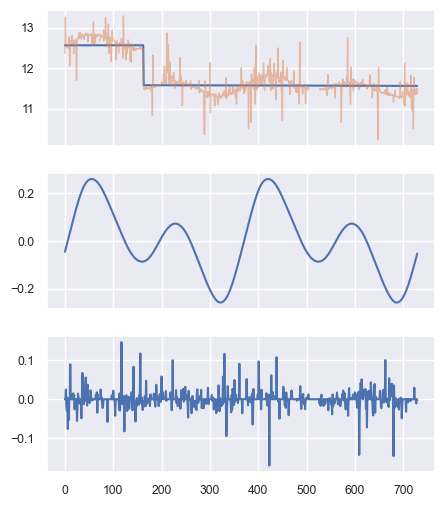

In [60]:
c1 = SumSquare(weight=1/len(metric)) # error
c2 = SumCard(weight=0.0003, diff=1) # s_hat
c3 = Aggregate([SumSquare(weight=10, diff=2), AverageEqual(0, period=365), Periodic(365)]) # seasonal

problem = Problem(metric, [c1,c2,c3], use_set=use_ixs)
problem.decompose()

s_error =  problem.decomposition[0]
s_hat = problem.decomposition[1]
s_seas =  problem.decomposition[2]

f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(5,6), sharex=True)

ax1.plot(s_hat)
ax1.plot(metric, linewidth=1, alpha=0.5)
ax2.plot(s_seas)
ax3.plot(s_error)

plt.show()

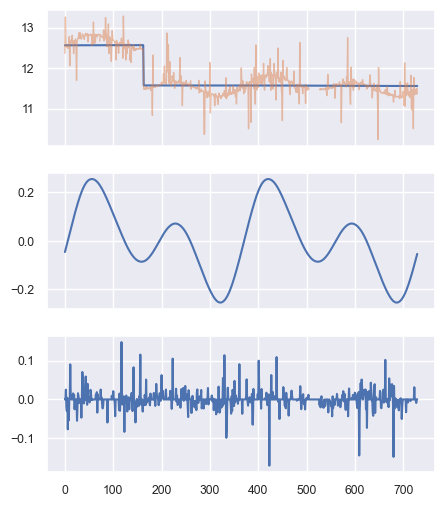

In [24]:
c1 = SumSquare(weight=1/len(metric)) # error
c2 = SumCard(weight=1/(len(metric)-1), diff=1) # s_hat
c3 = Aggregate([SumSquare(weight=15, diff=2), AverageEqual(0, period=365), Periodic(365)]) # seasonal

problem = Problem(metric, [c1,c2,c3], use_set=use_ixs)
problem.decompose()

s_error =  problem.decomposition[0]
s_hat = problem.decomposition[1]
s_seas =  problem.decomposition[2]

f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(5,6), sharex=True)

ax1.plot(s_hat)
ax1.plot(metric, linewidth=1, alpha=0.5)
ax2.plot(s_seas)
ax3.plot(s_error)

plt.show()